In [5]:
using PyPlot,JLD2,MCMCDiagnostics
rc("font",family="serif")
include("CGS.jl")
include("MCMC.jl")

MCMC (generic function with 1 method)

### Plot of simulated years observed vs TTVs

In [6]:
include("decompose_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")
include("plot_ttvs.jl")

plot_ttvs (generic function with 2 methods)

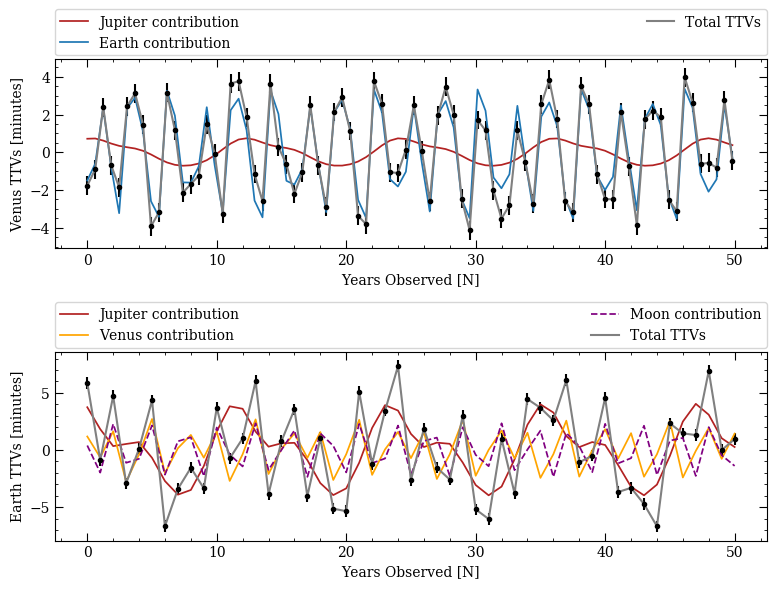

In [3]:
@load ("OUTPUTS/moon_fitmtry3params.jld2")
@load ("mcmc_mtry3results.jld2") 
plot_ttvs(true)
# savefig("ttvs.png")

In [ ]:
# plot_ttvs(true)
# savefig("embttvs.png")

In [4]:
plot_likelihood(true)

UndefVarError: UndefVarError: lprob_p3 not defined

In [12]:
2457580.87634+0.00034

2.4575808766799998e6

In [13]:
sigtt

133-element Array{Float64,1}:
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 ⋮                     
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224

In [15]:
0.00085 * 24 * 3600

73.44

In [16]:
45+15

60

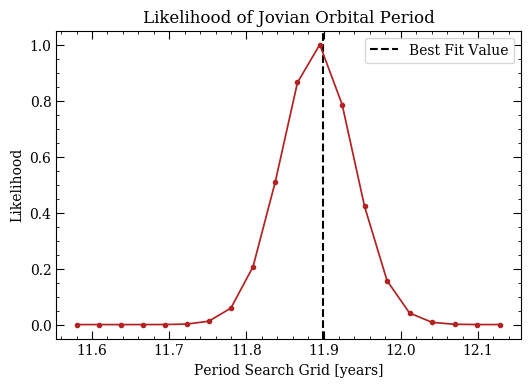

In [221]:
fig, ax1 = subplots(figsize=(6,4))
ax1.minorticks_on()
ax1.tick_params(which="major",direction="in",top="true",right="true",length=6)
ax1.tick_params(which="minor",direction="in",top="true",right="true",length=2)
axvline(param[12]/365.25,linestyle="--",color="black",label="Best Fit Value")
plot(p3/365.25,exp.((lprob_p3 .-maximum(lprob_p3))),linewidth=1.25,marker=".",color="firebrick") 
# plot!( -5:8,(-5:8).^2,inset = (1,bbox(0.1,0.0,0.4,0.4)),subplot = 2)
title("Likelihood of Jovian Orbital Period")
xlabel("Period Search Grid [years]")
ylabel("Likelihood")
legend()
# savefig("IMAGES/p3likelihood.png")

In [283]:
jd1 = 2.4332825e6
jd2 = 2.4515445e6
jdsize = 1000
offset = (jd1 + jd2)/2 
p3 = 10 .^ range(log10(500),stop=log10(5000),length=100)
phase = 0
deltaphi = range(dpin,stop=dpout,length=ndp)
for j=1:np3
    phase = p3[j]*range(0,stop=1,length=50) .+ offset
end

println(phase)

2.4424135e6:15.87424636663747:2.443191338071965e6


In [290]:
dt = (jd2 - jd1)/jdsize
t0 = range(jd1,stop=jd2-1,length = jdsize)
nyears = (jd2-jd1)/365.25 

49.998631074606436

In [286]:
collect(phase)

50-element Array{Float64,1}:
 2.4424135e6         
 2.442429374246367e6 
 2.442445248492733e6 
 2.4424611227391e6   
 2.4424769969854667e6
 2.442492871231833e6 
 2.4425087454782e6   
 2.4425246197245666e6
 2.442540493970933e6 
 2.4425563682172997e6
 2.4425722424636665e6
 2.442588116710033e6 
 2.4426039909563996e6
 ⋮                   
 2.4430167213619323e6
 2.4430325956082987e6
 2.4430484698546655e6
 2.4430643441010322e6
 2.4430802183473986e6
 2.4430960925937654e6
 2.443111966840132e6 
 2.4431278410864985e6
 2.4431437153328652e6
 2.443159589579232e6 
 2.443175463825599e6 
 2.443191338071965e6 

In [ ]:
@load ("mcmc_mtry3results.jld2")
@load ("OUTPUTS/moon_fitmtry3params.jld2")
tmax = sqrt.(vec(par_mcmc[:,iburn:nsteps,16].^2) + vec(par_mcmc[:,iburn:nsteps,17].^2))
mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
n1,n2,n3 = ntrans
ttsim2 = (ttmodel[n1+1:n1+n2].-t02)./365.25 


In [82]:
pname = ["mu_1","P_1","t01","e1 cos(om1)","e1 sin(om1)",
            "mu_2","P_2","t02","e2 cos(om2)","e2 sin(om2)",
            "mu_3","P_3","t03","e3 cos(om3)","e3 sin(om3)",
            "tmax sin(phi0)","tmax cos(phi0)","deltaphi"]

18-element Array{String,1}:
 "mu_1"          
 "P_1"           
 "t01"           
 "e1 cos(om1)"   
 "e1 sin(om1)"   
 "mu_2"          
 "P_2"           
 "t02"           
 "e2 cos(om2)"   
 "e2 sin(om2)"   
 "mu_3"          
 "P_3"           
 "t03"           
 "e3 cos(om3)"   
 "e3 sin(om3)"   
 "tmax sin(phi0)"
 "tmax cos(phi0)"
 "deltaphi"      

In [249]:
function vectorize_data(include_moon::Bool=false)
    names = ["mu", "P", "t0", "e cos(om)", "e sin(om)"]
    planet = ["venus", "earth", "jupiter"]
    nparam = length(names)*length(planet)+1
#     state_total = zeros((nsteps-iburn)*nwalkers+50,nparam-1)
    for iparam=1:nparam-1
#     state_total[:,iparam] += vec(par_mcmc[:,iburn:nsteps,iparam])
    if iparam < nparam
        pname = string(planet[div(iparam-1,5)+1]," ",names[mod(iparam-1,5)+1])
    end
        println("index: ",iparam, " ",pname," : ",pbest_global[iparam])
    end
#     for iparam=1:3
#     if iparam < nparam
end
# mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
# mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
# mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
# scatter(vec(par_mcmc[1:nwalkers,1:nsteps,1]),vec(par_mcmc[1:nwalkers,1:nsteps,5]))

vectorize_data (generic function with 2 methods)

In [250]:
vectorize_data(false)

index: 1 venus mu : 2.4400941294022936e-6
index: 2 venus P : 224.70077362581506
index: 3 venus t0 : 2.433503768774977e6
index: 4 venus e cos(om) : -0.007328894195584011
index: 5 venus e sin(om) : 0.0020534775024117742
index: 6 earth mu : 2.9954561266272332e-6
index: 7 earth P : 365.2564507566987
index: 8 earth t0 : 2.433624407591685e6
index: 9 earth e cos(om) : 0.007444837391202356
index: 10 earth e sin(om) : 0.00468779249816318
index: 11 jupiter mu : 0.0012445740058471665
index: 12 jupiter P : 4346.048466293495
index: 13 jupiter t0 : 2.4433983646784374e6
index: 14 jupiter e cos(om) : 0.0324036100900935
index: 15 jupiter e sin(om) : -0.02593064969074354


## MCMC Diagnostics

In [3]:
@load("mcmc_mtry1results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [11]:
nparam = 18  
samplesize = zeros(nparam)
for j=1:nwalkers
for i=1:nparam
  samplesize[i] += effective_sample_size(par_mcmc[j,:,i])
end
end
indepsamples = minimum(samplesize)
#   println("Independent Sample Size: ",indepsamples)


1600.6485560900187

In [436]:
@load ("mcmc_mtry3results.jld2")
@load ("OUTPUTS/moon_fitmtry3params.jld2")

17-element Array{Symbol,1}:
 :pbest_dp    
 :lprob_dp    
 :lprob_best  
 :pbest_global
 :ntrans      
 :nplanet     
 :tt0         
 :tt          
 :ttmodel     
 :sigtt       
 :p3in        
 :p3out       
 :np3         
 :nphase      
 :dpin        
 :dpout       
 :ndp         

In [437]:
function extract_data(filename)
	f = jldopen(String(filename), "r")
	return f
end
#unsure if this works within for loops
#might have used in 200000 step moon run on desktop

extract_data (generic function with 1 method)

In [7]:
extract_data("mcmc_testingresults.jld2")

UndefVarError: UndefVarError: extract_data not defined

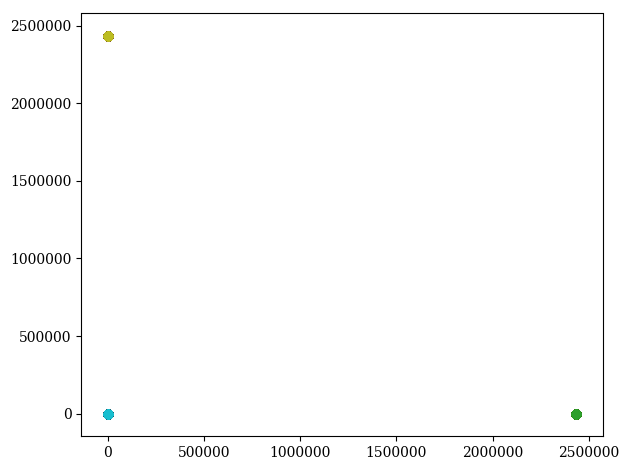

In [8]:
# figsize=(9,5)
figsize=(8,6)
for i=2:5
# subplot(5,1,i)
for j=1:i-1 
#  for i=2:nparam
# #   for j=1:i-1
scatter(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]),vec(par_mcmc[1:nwalkers,iburn:nsteps,j]))
# ylabel(pname[i])
end
end
tight_layout()


## Posterior Distributions

### Plot masses of Venus and Earth in $M_{\oplus}$

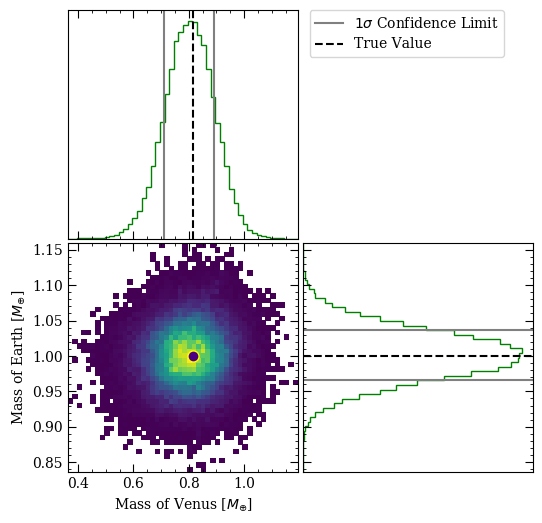

PyObject Text(26.700000000000003, 0.5, 'Mass of Earth [$M_{\\oplus}$]')

In [428]:
nbins = 50
xvalue = vec(par_mcmc[:,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,iburn:nsteps,6]).*CGS.MSUN/CGS.MEARTH
optx = param[1].* CGS.MSUN/CGS.MEARTH
opty = param[6].* CGS.MSUN/CGS.MEARTH
truex = 0.815
truey = 1
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Mass of Venus [$M_{\oplus}$]")
ylabel(L"Mass of Earth [$M_{\oplus}$]")
# savefig("massposteriors.png")

### Plot TTV of Earth due to Moon $t_{max}$ vs phase change of Moon per Earth year $\Delta \phi$

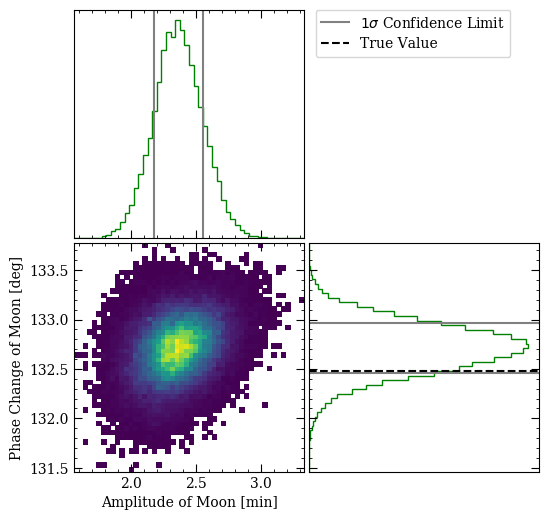

PyObject Text(24.000000000000014, 0.5, 'Phase Change of Moon [deg]')

In [432]:
# function plot_posterior(samples,bins,range)
# tmax = vec(sqrt(par_mcmc[:,iburn:nsteps,16]).^2 + vec(par_mcmc[:,iburn:nsteps,17]).^2)
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,16].^2) + vec(par_mcmc[:,iburn:nsteps,17].^2)).* (24 * 60)
yvalue = vec(par_mcmc[:,iburn:nsteps,18]).* 57.2957795 
optx = sqrt(param[16]^2 + param[17]^2).* (24 * 60)
opty = param[18].* 57.2957795 
# truex = 
truey = 2.3122 .* 57.2957795 
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Amplitude of Moon [min]")
ylabel("Phase Change of Moon [deg]")
# savefig("moonposteriors.png")

### Plot eccentricities of Venus and Earth

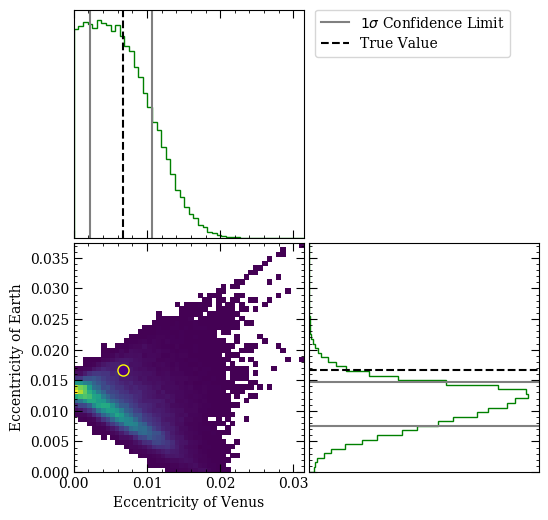

PyObject Text(0.5, 24.0, 'Eccentricity of Venus')

In [433]:
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,4]).^2 + vec(par_mcmc[:,iburn:nsteps,5]).^2)
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,9]).^2 + vec(par_mcmc[:,iburn:nsteps,10]).^2)
optx = sqrt(param[4]^2 + param[5]^2)
opty = sqrt(param[9]^2 + param[10]^2)
truex = 0.006772
truey = 0.0167086
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
ylabel("Eccentricity of Earth")
xlabel("Eccentricity of Venus")
# savefig("eccposteriors.png")

### Plot mass of Jupiter $M_{Jup}$ vs its eccentricity

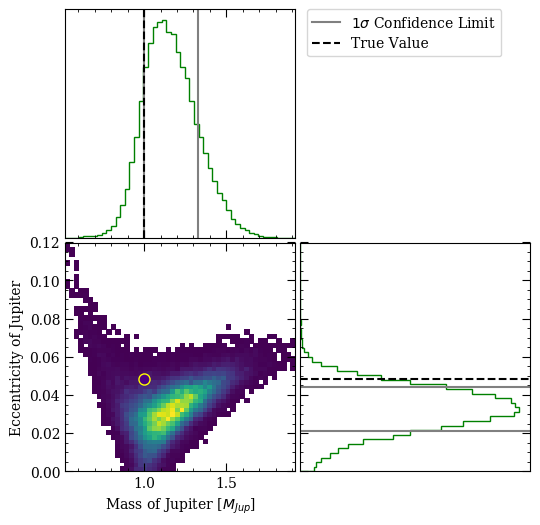

PyObject Text(0.5, 29.299999999999997, 'Mass of Jupiter [$M_{Jup}$]')

In [426]:
xvalue = vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MJUPITER
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,14]).^2 + vec(par_mcmc[:,iburn:nsteps,15]).^2)
optx = param[11].* CGS.MSUN/CGS.MJUPITER
opty = sqrt(param[14]^2 + param[15]^2)
truex = 1
truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
ylabel("Eccentricity of Jupiter")
xlabel(L"Mass of Jupiter [$M_{Jup}$]")
# savefig("jupiterposteriors.png")

### Plot time of inferior conjuction [JD - 24550000] $t_{03}$ vs Jupiter period $P_3$. 

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,11])
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,14]).^2 + vec(par_mcmc[:,iburn:nsteps,15]).^2)
optx = param[11].* CGS.MSUN/CGS.MJUPITER
opty = sqrt(param[14]^2 + param[15]^2)
truex = 1
truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
ylabel("Eccentricity of Jupiter")
xlabel(L"Mass of Jupiter [$M_{Jup}$]")

In [ ]:

function show_args(args)
  @show args
end


# include("full_run.jl")
include("run_pd_hyak.jl")
datafile = "../../data/T1_Spitzer_data.jld2"

#foutput = "T1_pd_MCMC_run_01.jld2"
foutput = string("T1_pd_MCMC_run_000_",show_args(ARGS)[1],".jld2")

numwalkers = 50
burnin = 1
thinning = 10
astep = 2.0
nsteps = 40000
run_pd(datafile,foutput,numwalkers,burnin,thinning,astep,nsteps;nout=10000)

In [ ]:
#slurm file includes
julia run_pd_background_01.jl 001 &

In [ ]:

@load ("OUTPUTS/moon_fitmtestparams.jld2")
label = "mtry1"
nsteps = 200000
nwalkers = 50
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

In [10]:
include("sim_times.jl")
include("fit_mysterybody.jl")

jd1 = 2.4332825e6
jd2 = 2.4515445e6
jdsize = 1000
p3in = 4230.0
p3out = 4430.0
np3 = 100
nphase = 100
dpin = 0.0 
dpout = 2*pi
ndp = 36

function full_run(label,sigma)
sim_times(jd1,jd2,jdsize,true,sigma,true)
datafile = string("INPUTS/tt_data",sigma,"sEMB.txt")
fit_planet3(datafile,label,jd1,jd2,jdsize,p3in,p3out,np3,nphase,true,sigma,true)
end


full_run (generic function with 1 method)

In [11]:
full_run("try003",30.0)

Initial parameters: [3.0e-6, 224.70077394470007, 2.433503765460372e6, 0.01, 0.01, 3.0e-6, 365.2564545041881, 2.433624402332964e6, 0.01, 0.01]
Initial chi-square: 1839.0970738805383
Finished 2-planet fit: [2.37425388927935e-6, 224.70077377829972, 2.4335037654681234e6, 0.0032637635694965864, 0.009992738112461756, 3.0424593142016426e-6, 365.2564537903443, 2.433624402323826e6, 0.015613928831187845, 0.0098614275660136]
Period: 4229.999999999999 chi: -371.01506065642235 Param: [2.222108682132765e-6, 224.70077377576982, 2.433503765439938e6, -0.009947773785706472, 0.0014601819263670708, 2.9743218099064124e-6, 365.2564548314295, 2.433624402176066e6, 0.005156924282544979, 0.004339342721426441, 0.0011273372936300879, 4229.999999999999, 2.4433936578315394e6, 0.03105226706459972, -0.029130741240974412]
Period: 4231.9743576935625 chi: -370.454952307879 Param: [2.222079202486263e-6, 224.70077377682688, 2.4335037654400114e6, -0.009893498772237505, 0.0014611956947786118, 2.974687115264301e-6, 365.25645

Period: 4271.655606951618 chi: -360.3666626997803 Param: [2.2247110945247736e-6, 224.7007737711158, 2.433503765442663e6, -0.008814490203333114, 0.0014964782722132512, 2.9819360315443586e-6, 365.2564537926792, 2.433624402215494e6, 0.006068974027592315, 0.004553673302207644, 0.001196361189368866, 4271.655606951618, 2.443397592558543e6, 0.03399821328181498, -0.027177008019118994]
Period: 4273.649407450871 chi: -359.93605315341705 Param: [2.2251406054975763e-6, 224.70077376951608, 2.4335037654428463e6, -0.00876171388565956, 0.00151527795815343, 2.982283929525669e-6, 365.25645373246977, 2.4336244022177006e6, 0.006111353600437227, 0.004574125157869177, 0.0011985423860809453, 4273.649407450871, 2.443397649566139e6, 0.03404564825356927, -0.02711728537007438]
Period: 4275.644138558953 chi: -359.5142714003841 Param: [2.225396182264735e-6, 224.70077376767384, 2.433503765443057e6, -0.008699192882432675, 0.0015068118003005912, 2.9827136743544055e-6, 365.25645367332294, 2.4336244022199e6, 0.00616189

Period: 4315.7348589794265 chi: -353.29578538413335 Param: [2.231954561287049e-6, 224.70077369687598, 2.4335037654485973e6, -0.007609198582112182, 0.0015315827899821557, 2.990706982111506e-6, 365.25645230801075, 2.433624402268951e6, 0.007055829004944111, 0.004632222171726344, 0.0012345412347330267, 4315.7348589794265, 2.4434055898647164e6, 0.034150473106668605, -0.02526759141052864]
Period: 4317.749233523683 chi: -353.1120220785946 Param: [2.232362457066801e-6, 224.7007736919588, 2.433503765448936e6, -0.007554491390434003, 0.0015356716126141107, 2.9911258876311328e-6, 365.2564522325722, 2.433624402271606e6, 0.007101073101881504, 0.004633766520893641, 0.0012355501923639654, 4317.749233523683, 2.4434060171608445e6, 0.03410530190224697, -0.02518579916104593]
Period: 4319.764548279731 chi: -352.9416589263941 Param: [2.232567968915267e-6, 224.7007736866633, 2.4335037654492897e6, -0.007515732532911958, 0.0015280897671722893, 2.99145365942554e-6, 365.2564521562659, 2.433624402274266e6, 0.0071

Period: 4360.268965199171 chi: -352.47055500585316 Param: [2.2383400945782137e-6, 224.70077354783518, 2.4335037654578215e6, -0.006420427153589639, 0.0013949244130081362, 3.000575458295673e-6, 365.2564505226627, 2.4336244023303115e6, 0.008052018422319238, 0.004389099580784571, 0.001237762658963741, 4360.268965199171, 2.4434211429225397e6, 0.03164705984168046, -0.02301887203826374]
Period: 4362.304126092185 chi: -352.59501909008753 Param: [2.2385879295725195e-6, 224.70077353931165, 2.433503765458319e6, -0.006358901597571536, 0.001370277782052694, 3.001081940941519e-6, 365.25645043744566, 2.43362440233318e6, 0.00810304365152669, 0.004358345548792821, 0.001236736025708723, 4362.304126092185, 2.44342215206917e6, 0.031441106400230935, -0.022907021772178397]
Period: 4364.340236899043 chi: -352.73322496742 Param: [2.2386405882958905e-6, 224.70077353037365, 2.433503765458834e6, -0.006310040325509164, 0.0013530140771979065, 3.001555919427607e-6, 365.2564503508387, 2.4336244023360857e6, 0.0081459

Period: 4405.262619255287 chi: -358.1506440582888 Param: [2.2426234667970924e-6, 224.70077334341002, 2.433503765469586e6, -0.005280108077791885, 0.0008899520873537005, 3.0104971550046237e-6, 365.2564486254243, 2.4336244023934132e6, 0.009016805290820211, 0.0036853056356615653, 0.0012099864238773448, 4405.262619255287, 2.443445441248507e6, 0.02692416297550834, -0.020164104122030176]
Period: 4407.3187809915735 chi: -358.53941324989194 Param: [2.242715735732186e-6, 224.70077333314538, 2.433503765470165e6, -0.005241825234446504, 0.000866286436377047, 3.010851153628505e-6, 365.2564485384836, 2.4336244023962575e6, 0.009049500887596, 0.0036500023165809284, 0.0012083270452986359, 4407.3187809915735, 2.443446700351251e6, 0.026678322250656222, -0.020009881587709607]
Period: 4409.375902443875 chi: -358.93780001039454 Param: [2.2430008163179503e-6, 224.7007733233706, 2.4335037654707185e6, -0.005201291681205889, 0.0008479553605969066, 3.0111899658898848e-6, 365.2564484536359, 2.4336244023990408e6, 0

(-351.9785603577108, [2.236293467781324e-6, 224.70077361174722, 2.4335037654539985e6, -0.006862130019070872, 0.0014725146152230325, 2.996777118923702e-6, 365.25645121776586, 2.4336244023066927e6, 0.007679556372531956, 0.004522807260345528, 0.0012402519786224064, 4343.361366795386, 2.443414235792582e6, 0.03286410069219122, -0.023945660323045785])

In [ ]:
full_run()